## Using Customer Data to Predict Application Success
#### Eric Romero

### Table of Contents:

   * <a href="#1"> Business Understanding </a>
   * <a href="#2"> Data Evaluation/Engineering </a>
   * <a href="#3"> Modeling Preparations </a>
   * <a href="#4"> Model Building and Evaluation </a>
   * <a href="#5"> Model Interpretability and Explainability </a>
   * <a href="#6"> Conclusions </a>

<a id="1"></a>
## Business Understanding
**Problem description**
One aspect of our business involves calling potential customers (leads) who inquire about our products. In the best-case scenario, these customers work with our licensed sales agents to submit an application for a new policy (we consider this a sale). The typical structure this process takes is:

1. We create a **prediction score** for all available uncontacted leads at the time of a match.
2. The agent will match with the “best” *uncontacted* lead and call that lead.
3. If the customer is not available, we put the lead back in the inventory of available leads for later consideration.  
4. If the customer is available, the agent engages in a conversation; this is a **contact**.
5. Agent assesses the customer’s interest and eligibility in our products.
6. If applicable, the agent provides custom pricing information; this is a **quote**.
7. If the customer is interested, the agent helps the customer submit an **application**.

**Problem:** How do we use available data to improve our prediction score (1) to maximize sales?

<a id="2"></a>
## Data Evaluation/Engineering

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv('jds_project_data.csv')
df.shape

(147656, 26)

In [2]:
pd.set_option('display.max_columns', None)
df.head()

,match_id,lead_id,agent_id,lead_source_id,lead_creation_date,matched_at,dial_count,source_type,state,gender,age,lead_cost,result,lead_age_at_acquisition,prepaid_phone,phone_in_service,phone_type,email_score,email_valid,phone_score,contact_score,block_score,email_reason,contact,quote,app
0,40667,12289,174,8,1/19/2021 12:08,1/19/2021 12:43,1,DELIVERY,AR,Female,65,4.22,2.0,57.7072,Y,I2,NaN,10.0,1.0,62,36.0,47.948863,0.0,0,0,0
1,144108,30625,176,83,1/22/2021 20:41,1/25/2021 16:03,2,FORM,MS,NaN,66,13.79,NaN,NaN,N,A7,NaN,95.0,1.0,98,96.5,73.383948,0.0,0,0,0
2,4314,4446,91,50,1/17/2021 18:48,1/18/2021 9:25,3,DELIVERY,WI,Male,74,65.00,2.0,351.5950,Y,A7,NaN,85.0,1.0,98,91.5,58.877858,0.0,0,0,0
3,89955,20851,228,15,1/20/2021 18:53,1/21/2021 11:17,4,DELIVERY,OK,Female,80,1.76,2.0,4.6066,N,A7,NaN,85.0,1.0,99,92.0,55.408187,0.0,0,0,0
4,77985,20544,168,109,1/20/2021 17:57,1/20/2021 17:57,0,FORM,WY,NaN,78,48.07,NaN,NaN,N,I1,NaN,85.0,1.0,50,67.5,77.281536,0.0,0,0,0


In [3]:
df.describe()

,match_id,lead_id,agent_id,lead_source_id,dial_count,age,lead_cost,result,lead_age_at_acquisition,phone_type,email_score,email_valid,phone_score,contact_score,block_score,email_reason,contact,quote,app
count,147656.000000,147656.000000,147656.000000,147656.000000,147656.000000,147656.00000,147656.000000,108572.000000,1.060410e+05,0.0,147222.000000,147222.000000,147656.000000,147222.000000,147656.000000,147222.000000,147656.000000,147656.000000,147656.000000
mean,73828.500000,18091.522525,143.007308,48.922645,2.465900,69.47912,24.762718,2.060771,6.167786e+03,NaN,76.955924,0.984812,83.863561,80.413664,60.044404,0.015188,0.126842,0.014832,0.007064
std,42624.760011,10109.974973,78.171827,30.328654,2.132447,6.89628,25.844823,0.238910,7.432692e+04,NaN,19.612210,0.173624,19.983432,15.280422,9.973104,0.173624,0.332797,0.120880,0.083749
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.010000,2.000000,0.000000e+00,NaN,0.000000,-1.000000,0.000000,5.000000,13.042236,0.000000,0.000000,0.000000,0.000000
25%,36914.750000,9631.000000,76.000000,29.000000,1.000000,64.00000,4.630000,2.000000,1.761100e+00,NaN,80.000000,1.000000,70.000000,74.000000,53.335899,0.000000,0.000000,0.000000,0.000000
50%,73828.500000,17978.000000,146.000000,44.000000,2.000000,67.00000,17.270000,2.000000,3.360200e+00,NaN,85.000000,1.000000,98.000000,87.000000,60.085261,0.000000,0.000000,0.000000,0.000000
75%,110742.250000,25889.000000,212.000000,66.000000,4.000000,73.00000,38.880000,2.000000,6.031540e+01,NaN,85.000000,1.000000,99.000000,92.000000,66.775954,0.000000,0.000000,0.000000,0.000000
max,147656.000000,38167.000000,272.000000,119.000000,11.000000,121.00000,526.500000,3.000000,5.696218e+06,NaN,95.000000,1.000000,99.000000,97.000000,100.000000,2.000000,1.000000,1.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147656 entries, 0 to 147655
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   match_id                 147656 non-null  int64  
 1   lead_id                  147656 non-null  int64  
 2   agent_id                 147656 non-null  int64  
 3   lead_source_id           147656 non-null  int64  
 4   lead_creation_date       147656 non-null  object 
 5   matched_at               147656 non-null  object 
 6   dial_count               147656 non-null  int64  
 7   source_type              147656 non-null  object 
 8   state                    147656 non-null  object 
 9   gender                   118781 non-null  object 
 10  age                      147656 non-null  int64  
 11  lead_cost                147656 non-null  float64
 12  result                   108572 non-null  float64
 13  lead_age_at_acquisition  106041 non-null  float64
 14  prep

#### Missing Values

In [5]:
print (df.isnull().sum())

match_id                        0
lead_id                         0
agent_id                        0
lead_source_id                  0
lead_creation_date              0
matched_at                      0
dial_count                      0
source_type                     0
state                           0
gender                      28875
age                             0
lead_cost                       0
result                      39084
lead_age_at_acquisition     41615
prepaid_phone                 196
phone_in_service              196
phone_type                 147656
email_score                   434
email_valid                   434
phone_score                     0
contact_score                 434
block_score                     0
email_reason                  434
contact                         0
quote                           0
app                             0
dtype: int64


#### Initial Data Observations:
* Dataset contains mixed data types
* Two date and time attributes that will need to be converted to useable format
* Several ID attributes that will likely not be useful for predictive models and should be removed
* Several Missing data points in multiple columns
    * **Phone_type** is missing completely therefore this column should be removed
    * Attributes missing <500: if unable to impute missing rows, they can possibly be removed with little impact on the overall data
    * Attributes missing >500: need to be looked at individually
* Differences in magnitude of values between attributes
    * Data will likely need to normalized

In [6]:
df = df.drop('phone_type',axis=1) #dropping column as it is missing all values

In [7]:
#### Analysis of missing values in 'gender'
from collections import Counter
df['gender'].value_counts()

Female    73225
Male      45556
Name: gender, dtype: int64

* **Gender** is heavily skewed towards female, with nearly 30,000 missing values.
    * Missing values will be replaced with a "No Gender" category, not only will this preserve the original data but allow analysis for customers that do not wish to include gender for various reasons.
    * These features will also be one-hot-encoded to be useful in model building


In [8]:
df['gender'] = df['gender'].replace(np.nan, 'No Gender')
df['gender'].value_counts()

Female       73225
Male         45556
No Gender    28875
Name: gender, dtype: int64

In [9]:
#### Analysis of missing values in 'result'
df['result'].value_counts()

2.0    101974
3.0      6598
Name: result, dtype: int64

* **Result** consists of exact values mostly as 2 and some 3, while approximately 39,000 are unknown.
    * First assumption is that this is an important attribute based on the title and that it makes up significant portion of the data.
    * This is possibly a count of some kind, however without further information instead it will be assumed that this is categorical in nature.
    * To preserve the data that is present, missing values will be replaced with a new category (0)

In [10]:
df['result'] = df['result'].replace(np.nan, 0)
df['result'].value_counts()

2.0    101974
0.0     39084
3.0      6598
Name: result, dtype: int64

In [11]:
#### Analysis of missing values in 'prepaid_phone'
df['prepaid_phone'].value_counts()

N    129555
Y     17905
Name: prepaid_phone, dtype: int64

* The **prepaid_phone** attribute is overhwelmingly 'N' and therefore missing values will be assumed as 'N' to preserve other data in the row

In [12]:
df['prepaid_phone'] = df['prepaid_phone'].replace(np.nan, 'N')

In [13]:
#### Analysis of missing values in 'phone_in_service'
df['phone_in_service'].value_counts()

A7    129426
I1      4704
A1      3319
I2      2162
A2      1943
A6      1277
A5      1141
I3       942
A4       893
A3       485
I4       460
U        448
I5       169
I6        91
Name: phone_in_service, dtype: int64

* For **phone_in_service** missing values will be replaced with the most common value of 'A7' to preserve other data in the row

In [14]:
df['phone_in_service'] = df['phone_in_service'].replace(np.nan, 'A7')

In [15]:
#### Analysis of missing values in 'email_score'
df['email_score'].value_counts()

85.0    78912
80.0    22336
95.0    12849
30.0     6326
75.0     6216
70.0     5382
40.0     4334
10.0     3616
60.0     3565
90.0     1348
0.0      1118
20.0      797
50.0      423
Name: email_score, dtype: int64

In [16]:
#### Analysis of missing values in 'email_valid'
df['email_valid'].value_counts()

 1.0    146104
-1.0      1118
Name: email_valid, dtype: int64

In [17]:
#### Analysis of missing values in 'email_reason'
df['email_reason'].value_counts()

0.0    146104
2.0      1118
Name: email_reason, dtype: int64

* It is immediately notable that all email attributes, including contact scores, are missing the same number of data points and are likely related.
    * **email score:** can be imputed from the mean, this would represent the overall average for the company, also the missing values were small in number so this should have little impact on the data while preserving the information in the row.
    * **email_valid:** assuming *-1.0* to represent invalid emails, missing values are not known to be invalid necessarily, a category(0) will be included here to differentiate the email scores that will be imputed for these rows
    * **email_reason:** looks to be categorical in nature, without further information a category(1) will be created to differentiate these values and preserve row data.

In [18]:
df['email_valid'] = df['email_valid'].replace(np.nan, 0)
df['email_reason'] = df['email_reason'].replace(np.nan, 1)

In [19]:
df['email_score'] = df['email_score'].replace(np.nan, df['email_score'].mean(axis = 0, skipna = True)) #replace NaN with column mean

In [20]:
#### Analysis of missing values in 'contact_score'
df['contact_score'].value_counts()

92.0    31911
91.5    15573
78.5     7355
89.5     6822
97.0     6158
        ...  
45.5        2
16.0        2
35.5        2
26.5        1
20.5        1
Name: contact_score, Length: 157, dtype: int64

* For **contact_score** missing values will be imputed from the mean similarly to **email_score**. This would represent the overall average for the company, in addition the missing values were small in number so this should have little impact on the data while preserving the information in the row.

In [21]:
df['contact_score'] = df['contact_score'].replace(np.nan, df['contact_score'].mean(axis = 0, skipna = True)) #replace NaN with column mean

In [22]:
#### Analysis of missing values in 'lead_age_at_acquisition'
from collections import Counter
df['lead_age_at_acquisition'].value_counts()

0.0000        447
1.3991         33
2.0318         26
86401.3300     25
2.3959         25
             ... 
59.8614         1
635.8034        1
132.9756        1
86393.8750      1
1.2108          1
Name: lead_age_at_acquisition, Length: 23968, dtype: int64

* **lead_age_at_acquisition** is assumed to represent how long the lead took to be acquired.
    * This may have some connection with the date/time listings in the dataset which have been converted into a usable format below.
    * If further information were possible to obtain, imputating these missing values based on the timestamps of lead creation and match time may be a better alternative (see later section)
    * Without this information however, missing values will be assumed as unknowns. Using an imputed mean would be a possible option here, however that would make assumptions about the acquisition having taken place. Instead it will be assumed that acquisition did not take place and were therefore at value 0, which was also the most common value in the attribute.
    * This also makes an assumption that 0 represents **no acquisition** as 0 time in age would have little logical meaning.

In [23]:
df['lead_age_at_acquisition'] = df['lead_age_at_acquisition'].replace(np.nan, 0)

#### Recheck Missing Values

In [24]:
print (df.isnull().sum())

match_id                   0
lead_id                    0
agent_id                   0
lead_source_id             0
lead_creation_date         0
matched_at                 0
dial_count                 0
source_type                0
state                      0
gender                     0
age                        0
lead_cost                  0
result                     0
lead_age_at_acquisition    0
prepaid_phone              0
phone_in_service           0
email_score                0
email_valid                0
phone_score                0
contact_score              0
block_score                0
email_reason               0
contact                    0
quote                      0
app                        0
dtype: int64


#### Date/Time Conversion to Timestamp

In [25]:
import datetime as dt
d = '1/19/2021 12:08' #sample date
f = '%m/%d/%Y %H:%M' #format of dates
date_string = pd.to_datetime(df['lead_creation_date'], format=f, errors='coerce') #converts to useable format
timestamp = pd.DataFrame(date_string.values.astype(np.int64)) #creates timestamp for data
df['lead_creation_date_ts'] = timestamp #adds timestamp version of dates back into data

In [26]:
date_string = pd.to_datetime(df['matched_at'], format=f, errors='coerce') #converts to useable format
timestamp = pd.DataFrame(date_string.values.astype(np.int64)) #creates timestamp for data
df['matched_at_ts'] = timestamp #adds timestamp version of dates back into data

In [27]:
df['time_to_match'] = df['matched_at_ts'] - df['lead_creation_date_ts'] #creates new attribute for difference between creation of lead and match date

* Date/times were converted to timestamps for computation
    * Possible usefulness for prediction by calculating the time (in seconds) from lead_creation_date to the matched_at date as this will give some indication of how long they took to be matched.

#### Target Variable Analysis
* Based on the problem description, a "sale" is considered to take place at submission of an application
    * Target category is therefore assumed to be at 'app' value = 1
    * App category is heavily skewed toward value = 0
        * Will need to utilize a sampling method to improve prediction performance on minority class

In [28]:
df['app'].value_counts()

0    146613
1      1043
Name: app, dtype: int64

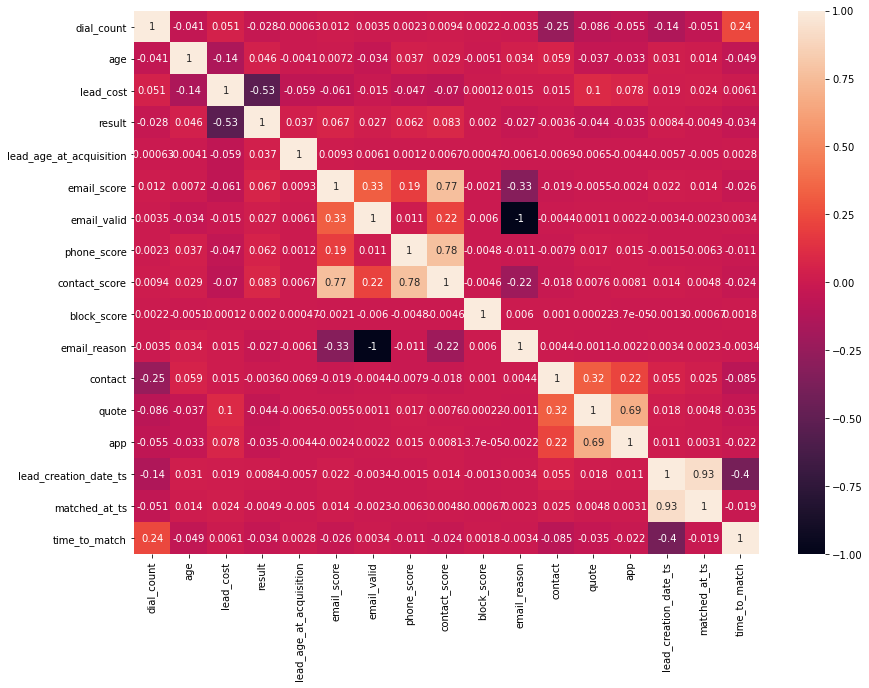

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
c = df.corr()
plt.figure(figsize=(14,10))
sns.heatmap(c, annot=True)
plt.show()

* Based on the problem statement **Contact** and **Quote** were specifically identified as important features, supported by their correlations seen in the above matrix. These attributes deserve special investigations in relation to the target category.

In [31]:
df['age'].value_counts()

64    43553
65    19441
66     8962
67     7533
68     6940
      ...  
24        1
44        1
45        1
32        1
0         1
Name: age, Length: 95, dtype: int64

<AxesSubplot:xlabel='age', ylabel='count'>

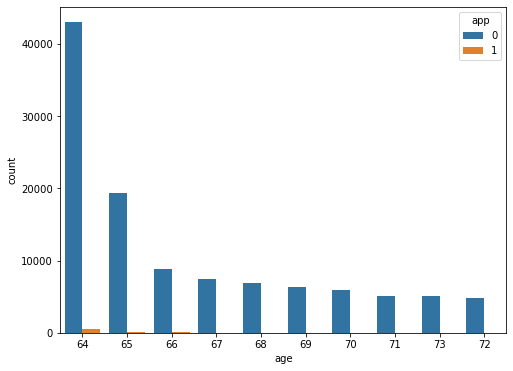

In [430]:
plt.figure(figsize=(8,6))
sns.countplot(data=df,x='age',hue='app',order=df.age.value_counts().iloc[:10].index)

* Investigating Age groups that submitted applications, we find that the top 10 ages were within the range 64 to 72.
    * Age 64 in particular is the most prevalent age group in the data as well as those with highest rate of submitted applications.

<AxesSubplot:xlabel='contact_score', ylabel='phone_score'>

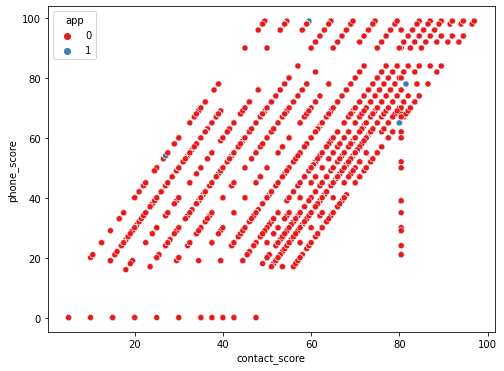

In [421]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df,x='contact_score',y='phone_score',hue='app',palette='Set1')

<AxesSubplot:xlabel='contact_score', ylabel='email_score'>

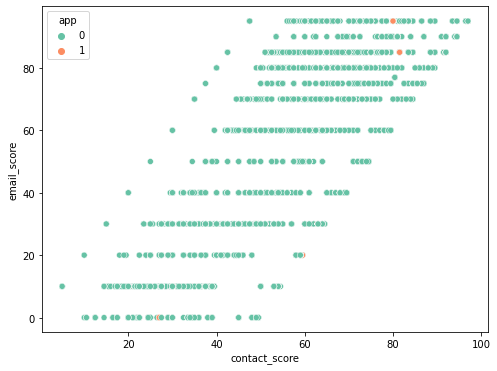

In [424]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df,x='contact_score',y='email_score',hue='app',palette='Set2')

* Investigating Contact, Phone and Email Scores displays a linear relationship as expected. 
* Application submission appears to be concentrated at higher levels as would also be expected, though not in any apparent patterns.
    * Some scores for submitted applications vary between contact and other types scoring.

<AxesSubplot:xlabel='quote', ylabel='count'>

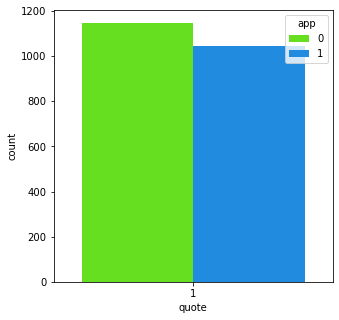

In [415]:
plt.figure(figsize=(5,5))
sns.countplot(data=df,x='quote',hue='app',palette='gist_rainbow',order=df.quote.value_counts().iloc[1:2].index)

<AxesSubplot:xlabel='contact', ylabel='count'>

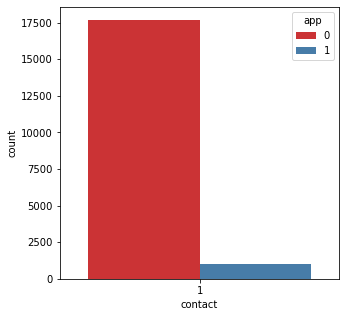

In [416]:
plt.figure(figsize=(5,5))
sns.countplot(data=df,x='contact',hue='app',palette='Set1',order=df.contact.value_counts().iloc[1:2].index)

* Above we see customers that were identified as positive for **quote** or **contact** categories. 
    * These are additionally separated by which customers did or did not submit an application.
    * In comparison we see customers were far more likely to submit an application based on receiving a quote then by contact alone. 
        * This makes sense as customers are offered quotes based on expressed interest after contact, so they are likely to be highly related.

<a id="3"></a>
## Modeling Preparations

In [32]:
#Removal of ID attributes (assuming these to be unimportant for modeling purposes) and date columns that were converted to timestamps
df = df.drop(['match_id','lead_id','agent_id','lead_source_id','lead_creation_date','matched_at'],axis=1)
df.head()

,dial_count,source_type,state,gender,age,lead_cost,result,lead_age_at_acquisition,prepaid_phone,phone_in_service,email_score,email_valid,phone_score,contact_score,block_score,email_reason,contact,quote,app,lead_creation_date_ts,matched_at_ts,time_to_match
0,1,DELIVERY,AR,Female,65,4.22,2.0,57.7072,Y,I2,10.0,1.0,62,36.0,47.948863,0.0,0,0,0,1611058080000000000,1611060180000000000,2100000000000
1,2,FORM,MS,No Gender,66,13.79,0.0,0.0000,N,A7,95.0,1.0,98,96.5,73.383948,0.0,0,0,0,1611348060000000000,1611590580000000000,242520000000000
2,3,DELIVERY,WI,Male,74,65.00,2.0,351.5950,Y,A7,85.0,1.0,98,91.5,58.877858,0.0,0,0,0,1610909280000000000,1610961900000000000,52620000000000
3,4,DELIVERY,OK,Female,80,1.76,2.0,4.6066,N,A7,85.0,1.0,99,92.0,55.408187,0.0,0,0,0,1611168780000000000,1611227820000000000,59040000000000
4,0,FORM,WY,No Gender,78,48.07,0.0,0.0000,N,I1,85.0,1.0,50,67.5,77.281536,0.0,0,0,0,1611165420000000000,1611165420000000000,0


#### One Hot Encoding

* Non-numeric categories will need to be encoded for use with modeling

In [55]:
from sklearn.preprocessing import OneHotEncoder
encoded_df = pd.DataFrame()
encoded_df = encoded_df.append(pd.get_dummies(df))

In [34]:
encoded_df.head()

,dial_count,age,lead_cost,result,lead_age_at_acquisition,email_score,email_valid,phone_score,contact_score,block_score,email_reason,contact,quote,app,lead_creation_date_ts,matched_at_ts,time_to_match,source_type_DELIVERY,source_type_FORM,state_AL,state_AR,state_AZ,state_CO,state_DE,state_GA,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MD,state_MI,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NV,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_WI,state_WV,state_WY,gender_Female,gender_Male,gender_No Gender,prepaid_phone_N,prepaid_phone_Y,phone_in_service_A1,phone_in_service_A2,phone_in_service_A3,phone_in_service_A4,phone_in_service_A5,phone_in_service_A6,phone_in_service_A7,phone_in_service_I1,phone_in_service_I2,phone_in_service_I3,phone_in_service_I4,phone_in_service_I5,phone_in_service_I6,phone_in_service_U
0,1,65,4.22,2.0,57.7072,10.0,1.0,62,36.0,47.948863,0.0,0,0,0,1611058080000000000,1611060180000000000,2100000000000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2,66,13.79,0.0,0.0000,95.0,1.0,98,96.5,73.383948,0.0,0,0,0,1611348060000000000,1611590580000000000,242520000000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,3,74,65.00,2.0,351.5950,85.0,1.0,98,91.5,58.877858,0.0,0,0,0,1610909280000000000,1610961900000000000,52620000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,4,80,1.76,2.0,4.6066,85.0,1.0,99,92.0,55.408187,0.0,0,0,0,1611168780000000000,1611227820000000000,59040000000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,78,48.07,0.0,0.0000,85.0,1.0,50,67.5,77.281536,0.0,0,0,0,1611165420000000000,1611165420000000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Data Normalization
* Training data will be normalized to reduce differences in magnitude of values

In [35]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

# Assigning features and target variable
X = encoded_df.drop(columns=['app'])
y = encoded_df.loc[:,'app']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# fit on the training dataset
scaler.fit(X_train)

# scale the training dataset
X_train = scaler.transform(X_train)

# scale the test dataset
X_test = scaler.transform(X_test)

In [36]:
y_train.value_counts() #check for balancing

0    117288
1       836
Name: app, dtype: int64

#### SMOTE for Balancing Data

In [37]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_os, y_os = oversample.fit_resample(X_train, y_train)
y_os.value_counts() #check for balancing

1    117288
0    117288
Name: app, dtype: int64

In [60]:
X_test_os, y_test_os = oversample.fit_resample(X_test, y_test)
y_test_os.value_counts() #check for balancing

1    29325
0    29325
Name: app, dtype: int64

<a id="4"></a>
## Model Building and Evaluation
* Due to the heavily unbalanced dataset, Stratified 10-Fold cross validation will be used in order to ensure that each fold will remain representative of the distributions in the dataset as a whole.

#### Base Decision Tree Model

In [39]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [41]:
%%time
model = RandomForestClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=123)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.997
Wall time: 1min 29s


#### Model Adjusted with SMOTE Balancing

In [42]:
%%time
os_scores = cross_val_score(model, X_os, y_os, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(os_scores))

Mean ROC AUC: 1.000
Wall time: 8min 59s


* The scoring is suspiciously high for both the base and SMOTE model likely due to the imbalance in the application target. 
* The **quote** feature is also particularly concerning here for possible dataleakage as it makes up a significantly high amount of the correlation. 
    * Particularly because nearly all customers that received quotes also submitted an application, a quote almost automatically predicts an application etc.
* Analysis and removal of features leading to possible data leaks would be something to consider further to improve model predictions.
    * Possibly using **quote** as a alternate target may also be more useful in future considerations.

<a id="5"></a>
## Model Interpretability and Explainability

#### Base Random Forest Model Metrics

In [69]:
model.fit(X_train, y_train)
y_pred =model.predict(X_test)
print('Accuracy of Random Forest Classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of Random Forest Classifier on test set: 0.99


In [70]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29325
           1       0.53      0.23      0.32       207

    accuracy                           0.99     29532
   macro avg       0.76      0.62      0.66     29532
weighted avg       0.99      0.99      0.99     29532



<AxesSubplot:>

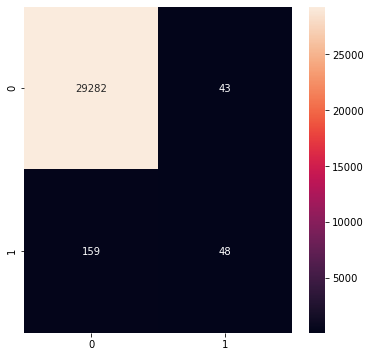

In [72]:
from sklearn.metrics import confusion_matrix
cf_test_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cf_test_matrix, annot=True, fmt='d')

#### Random Forest with SMOTE Metrics

In [78]:
model.fit(X_os, y_os)

RandomForestClassifier()

In [79]:
y_pred = model.predict(X_test)
print('Accuracy of Random Forest Classifier on test set: {:.2f}'.format(model.score(X_test, y_test)))

Accuracy of Random Forest Classifier on test set: 0.99


In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     29325
           1       0.51      0.80      0.62       207

    accuracy                           0.99     29532
   macro avg       0.75      0.90      0.81     29532
weighted avg       1.00      0.99      0.99     29532



<AxesSubplot:>

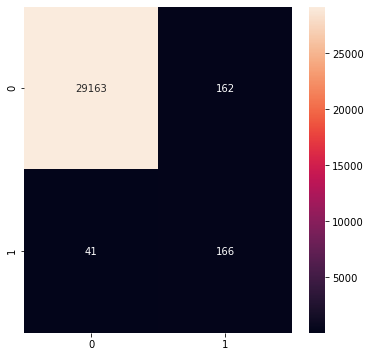

In [82]:
cf_test_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cf_test_matrix, annot=True, fmt='d')

#### Model Metrics

Normally for balanced data, accuracy would be the metric to use. However given the small presence of the target within the dataset, accuracy would be misleading as it is only very accurate at predicting the negative class (app = 0) simply because it makes up 99% of the data.

Instead we will look at the following metrics to measure how well the model does at predicting what we want to find (app = 1).

* **Precision** metric is the proportion of positive identifications were actually correct.
    * In the base model precision is at 0.53 which means about half of the selected predictions made were correct.
    * In the model trained on oversampled data the precision was slightly lower at 0.51
* **Recall** metric is the proportion of actual positives were identified correctly.
    * For the base model recall is at 0.23 meaning only roughly a quarter were correctly predicted of the possible positives it could have made for app = 1.
    * In the model trained on oversampled data the recall jumped to 0.8 which means this model is much better at identifying the actual positives, approximately 80% of the dataset minority.   
* **F1-score** also improved between models but this is a combined average of precision and recall so improvements were based on the increases to recall.

<a id="6"></a>
## Conclusions

Based on the base and oversampled model we can see that recall was the best metric for comparison between those two models. Changes to recall and f1-score would also be a useful metric to compare with similar models in production as it would show improvements in prediction capabilities.

Given additional time and resources there are several areas to look at for improvements. Investigating features for multicollinearity, 'quotes' for example, may be too deeply connected with applications and may haved caused some overfitting within the model reducing performance.
Looking at perdictions on different targets may also be an option. Using 'contact' for example, if a model were able to predict positive contacts this would also eventually lead to increases in application submissions. 
In these models I chose to use an oversampled dataset, undersampling is another option that is worth looking at as it may have better performance. 
Clustering may also be useful here to group features and investigate how they distinguish between the customers which may also improve model performance.